In [1]:
import argparse
from pathlib import Path
import numpy as np
from tqdm import tqdm

import cv2
from PIL import Image, ImageFilter
from matplotlib import pyplot as plt
plt.style.use('tableau-colorblind10')
import scienceplots
import pandas as pd
import json
from pprint import pprint
import seaborn as sns
import torch

import torchmetrics
from torchmetrics import PrecisionRecallCurve, ROC
from torchmetrics.functional.classification import binary_auroc, multiclass_auroc, binary_precision_recall_curve, multiclass_precision_recall_curve, confusion_matrix
from torchmetrics.functional.classification import binary_accuracy, multiclass_accuracy, binary_recall, binary_precision, multiclass_recall, multiclass_precision, binary_f1_score, multiclass_f1_score
from torchmetrics.utilities.compute import _auc_compute_without_check, _auc_compute

from utils.utils import get_roc_curve, get_pr_curve, get_confusion_matrix, get_optimal_operating_point

from scipy.stats import bootstrap as scp_bootstrap
from sklearn.metrics import roc_auc_score

import statistics
import logging

In [2]:
def bootstrap(y_pred, y_true, n):
    rng_seed = 42
    bootstrapped_scores = []
    bootstrapped_accuracy = []
    n_classes = 1
    if len(y_pred.shape) > 1:
        n_classes = y_pred.shape[1]
    # rng = np.random.RandomState(rng_seed=4)
    for i in range(n):
        # bootstrap by sampling with replacement on the prediction indices
        indices = torch.randint(low=0, high=len(y_true), size=(len(y_true), ))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue
        if len(y_pred.shape) > 1:
            score = multiclass_auroc(y_pred[indices], y_true[indices], num_classes=n_classes, average=None)
        else: 
            score = binary_auroc(y_pred[indices], y_true[indices])

        bootstrapped_scores.append(score)

    if n_classes > 1:
        for i in range(n_classes):
            # print('Class ', i)

            sub_array = [x[i] for x in bootstrapped_scores]
            # print(sub_array)
            sorted_scores = np.array(sub_array)
            sorted_scores.sort()

        # Computing the lower and upper bound of the 90% confidence interval
        # You can change the bounds percentiles to 0.025 and 0.975 to get
        # a 95% confidence interval instead.
            confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
            confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]


            # print("n={} Confidence interval for the score: [{:0.3f} - {:0.3}]".format(n,
            # confidence_lower, confidence_upper))

            # print('MEAN: ', np.mean(sorted_scores))
            # print('MEDIAN: ', statistics.median(sorted_scores))

        mean_array = [torch.mean(x) for x in bootstrapped_scores]

        sorted_scores = np.array(mean_array)
        sorted_scores.sort()

        confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
        confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]


        # print("n={} MEAN Confidence interval for the score: {:0.3f}".format(n,
        # confidence_lower, confidence_upper))
        
    else:

        sorted_scores = np.array(bootstrapped_scores)
        
        sorted_scores.sort()
        confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
        confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]

        # print("n={} Confidence interval for the score: [{:0.3f} - {:0.3}]".format(n,
        # confidence_lower, confidence_upper))

        # print('MEAN: ', np.mean(sorted_scores))
        # print('MEDIAN: ', statistics.median(sorted_scores))
    
    return np.mean(sorted_scores), (confidence_lower, confidence_upper)

In [3]:
# ckpt_dict = {
#     'TransMIL': {
#         # 'norm_rest': {'version': '893', 'epoch': '166', 'labels':['Normal', 'Disease']},
#         'norm_rest': {'version': '804', 'epoch': '30', 'labels':['Normal', 'Disease']},
#         'rest_rej': {'version': '63', 'epoch': '14', 'labels': ['Rest', 'Rejection']},
#         'norm_rej_rest': {'version': '53', 'epoch': '17', 'labels': ['Normal', 'Rejection', 'Rest']},
#     },
#     'CLAM': {
#         'norm_rest': {'labels':['NORMAL', 'REST']},
#         'rej_rest': {'labels': ['REJECTION', 'REST']},
#         'norm_rej_rest': {'labels': ['NORMAL', 'REJECTION', 'REST']},
#     },
#     'ViT': {
#         'norm_rest': {'version': '16', 'epoch': '142', 'labels':['Normal', 'Disease']},
#         'rej_rest': {'version': '1', 'epoch': 'last', 'labels': ['Rejection', 'Rest']},
#         'norm_rej_rest': {'version': '0', 'epoch': '226', 'labels': ['Normal', 'Rejection', 'Rest']},
#     },
    
#     'Inception': {
#         'norm_rest': {'labels':['Normal', 'Disease']},
#         'rest_rej': {'labels': ['Rest', 'Rejection']},
#         'norm_rej_rest': {'labels': ['Normal', 'Rejection', 'Rejection']},
#     }
# }

ckpt_dict = {
    'TransMIL':{
        'big_three': {'version': '14', 'epoch':'244', 'labels':['ccRCC', 'papRCC', 'chRCC']},
        'norm_rej_rest': {'version': '53', 'epoch': '17', 'labels': ['Normal', 'Rejection', 'Rest']},
    },
    'CLAM':{
        'big_three': {'labels':['ccRCC', 'papRCC', 'chRCC']},
        'norm_rej_rest': {'labels': ['NORMAL', 'REJECTION', 'REST']},
    },
    'ViT': {
        'big_three': {'version': '4', 'epoch': '27', 'labels': ['ccRCC', 'papRCC', 'chRCC']},
        'norm_rej_rest': {'version': '0', 'epoch': '226', 'labels': ['Normal', 'Rejection', 'Rest']},
    },
    'Inception': {
        'big_three': {'version': '2', 'epoch': '79', 'labels':['ccRCC', 'papRCC', 'chRCC']},
        'norm_rej_rest': {'labels': ['Normal', 'Rejection', 'Rejection']},
    },
    # 'vit': {
        
    # }
}

In [4]:
def generate_plots(project, model, t, version=None, epoch=None, labels=None, add_on=0):

    # print('-----------------------------------------------------------------------')
    # print(model, t, f'v{version}', f'e{epoch}', labels, add_on)
    # print('-----------------------------------------------------------------------')

    if project == 'DeepGraft':
        if model == 'CLAM':
            patient_result_csv_path = Path(f'/homeStor1/ylan/workspace/HIA/logs/{project}_Lancet/clam_mb/{project.upper()}_CLAMMB_TRAINFULL_{t}/RESULTS/TEST_RESULT_PATIENT_BASED_FULL.csv')
            threshold_csv_path = ''
        elif model == 'Inception':
            patient_result_csv_path = Path(f'/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/inception_results/{t}.csv')
            # test/inception_results/rest_rej.csv
            # Path(f'/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/inception_results/{t}.csv')
        else: 
            #TransMIL and ViT
            if model == 'TransMIL':
                a = 'features'
                root_dir = f'/homeStor1/ylan/workspace/TransMIL-DeepGraft/logs/{project}/{model}/{t}/_{a}_CrossEntropyLoss/lightning_logs/version_{version}/test_epoch_{epoch}_best'
            else:
                a = 'vit'
                root_dir = f'/homeStor1/ylan/workspace/TransMIL-DeepGraft/logs/{project}/{a}/{t}/_{a}_CrossEntropyLoss/lightning_logs/version_{version}/test_epoch_{epoch}'

            
            # print(root_dir)
            patient_result_csv_path = Path(root_dir) / 'TEST_RESULT_PATIENT.csv'
            # print(patient_result_csv_path)
            threshold_csv_path = f'{root_dir}/val_thresholds.csv'
            thresh_df = pd.read_csv(threshold_csv_path, index_col=False)
            optimal_threshold = thresh_df['patient'].values[0]
    elif project == 'RCC':
        if model == 'CLAM':
            patient_result_csv_path = Path(f'/homeStor1/ylan/workspace/HIA/logs/{project}_Lancet/clam_mb/{project.upper()}_CLAMMB_TRAINFULL_{t}/RESULTS/TEST_RESULT_PATIENT_BASED_FULL.csv')
            threshold_csv_path = ''
        # elif model == 'Inception':
        #     patient_result_csv_path = Path(f'/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/inception_results/{t}.csv')
            # test/inception_results/rest_rej.csv
            # Path(f'/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/inception_results/{t}.csv')
        else: 
            #TransMIL and ViT
            if model == 'TransMIL':
                a = 'features'
                root_dir = f'/homeStor1/ylan/workspace/TransMIL-DeepGraft/logs/{project}/{model}/{t}/_{a}_CrossEntropyLoss/lightning_logs/version_{version}/test_epoch_{epoch}'
            elif model == 'vit':
                a = 'vit'
                root_dir = f'/homeStor1/ylan/workspace/TransMIL-DeepGraft/logs/{project}/{a}/{t}/_{a}_CrossEntropyLoss/lightning_logs/version_{version}/test_epoch_{epoch}'
            elif model == 'Inception':
                a = 'inception'
                root_dir = f'/homeStor1/ylan/workspace/TransMIL-DeepGraft/logs/{project}/{a}/{t}/_{a}_CrossEntropyLoss/lightning_logs/version_{version}/test_epoch_{epoch}'

            
            # print(root_dir)
            patient_result_csv_path = Path(root_dir) / 'TEST_RESULT_PATIENT.csv'
            # print(patient_result_csv_path)
            threshold_csv_path = f'{root_dir}/val_thresholds.csv'
            thresh_df = pd.read_csv(threshold_csv_path, index_col=False)
            optimal_threshold = thresh_df['patient'].values[0]
    # output_dir = f'/homeStor1/ylan/DeepGraft_project/DeepGraft_Draft/figures/{model}'
    # Path(output_dir).mkdir(parents=True, exist_ok=True)

    patient_result = pd.read_csv(patient_result_csv_path)
    # pprint.pprint(patient_result)

    probs = np.array(patient_result[labels[int(add_on)]])
    if t == 'norm_rej_rest' or t == 'big_three':
        probs = np.array(patient_result[labels])
    probs = probs.squeeze()
    probs = torch.from_numpy(probs)

        
    # probs = torch.transpose(probs, 0,1).squeeze()
    target = np.array(patient_result.yTrue, dtype=int)
    target = torch.from_numpy(target)

    #swap values for rest_rej for it to align
    if t == 'rest_rej':
        probs = 1 - probs
        target = -1 * (target-1)
        t = 'rej_rest'
    # 
    if add_on == 0 and t != 'norm_rej_rest':
        probs = 1 - probs
        # target = 1 - target
    # if t == 'norm_rej_rest':
    #         optimal_threshold = 1/3
    # else:
    # if model == 'CLAM':
    #     if t == 'norm_rej_rest':
    #         optimal_threshold = 1/3
    #     else: optimal_threshold = 0.5
    # else: 
    if t == 'norm_rej_rest' or t == 'big_three':
        optimal_threshold = 1/3
    else: optimal_fpr, optimal_tpr, optimal_threshold = get_optimal_operating_point(probs.unsqueeze(0), target.unsqueeze(0))
    # if t != 'norm_rej_rest' or t != 'big_three':
    #     accuracy = binary_accuracy(probs, target, threshold=optimal_threshold)
    #     recall = binary_recall(probs, target, threshold=optimal_threshold)
    #     precision = binary_precision(probs, target, threshold=optimal_threshold)
    #     f1 = binary_f1_score(probs, target, threshold=optimal_threshold)
    # else: 
    #     accuracy = multiclass_accuracy(probs, target, num_classes=3, average=None)
    #     recall = multiclass_recall(probs, target, num_classes=3, average=None)
    #     precision = multiclass_precision(probs, target, num_classes=3, average=None)
    #     f1 = multiclass_f1_score(probs, target, num_classes=3, average=None)

    mean_auc, CI = bootstrap(probs, target, n=1000)
    return mean_auc, CI

In [5]:
model = 'TransMIL'
t = 'big_three'
version = ckpt_dict[model][t]['version']
epoch = ckpt_dict[model][t]['epoch']
labels = ckpt_dict[model][t]['labels']
add_on = 0

mean_auc, CI = generate_plots(project='RCC', model=model, t=t, version=version, epoch=epoch, labels=labels, add_on=1)
# print(mean_auc)

In [6]:
co2_path = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/model_co2_3stains.csv'
co2_df = pd.read_csv(co2_path)

pprint(co2_df)
model_co2 = co2_df.loc[co2_df.MODEL == model]['CO2eq'].values[0]
min_co2 = min(list(co2_df.CO2eq))
print(min_co2)


       MODEL      CO2eq
0  Inception     0.0771
1   TransMIL     0.0345
2       CLAM     0.0344
3        ViT     0.1008
4       PALM  1940.7760
0.0344


In [7]:
import math
import numpy as np
def SI(perf_metric, co2eq, co2eq_min):

    return math.pow(perf_metric, 2)/math.exp(-(co2eq - co2eq_min))
    # return math.pow(perf_metric, 2)/(np.log(co2eq - co2eq_min + 1)+1)
    # return math.pow(perf_metric, 2)/math.sqrt(co2eq - co2eq_min + 1)
    

In [8]:

model = 'CLAM'
version = 0
epoch = 0

model = 'TransMIL'
version = ckpt_dict[model][t]['version']
epoch = ckpt_dict[model][t]['epoch']
labels = ckpt_dict[model][t]['labels']

t = 'big_three'

add_on = 1

mean_auc, CI = generate_plots(project='RCC',model=model, t=t, version=version, epoch=epoch, labels=labels, add_on=1)

model_co2 = co2_df.loc[co2_df.MODEL == model]['CO2eq'].values[0]

print(model_co2)

SI(mean_auc, model_co2, min_co2)

0.0345


0.9561290247483151

In [9]:

renwableRatioCSVPath = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/countryRenewableRatio.csv'
re_ratio = pd.read_csv(renwableRatioCSVPath)

pprint(re_ratio)
country_list = list(re_ratio.Country)
print(country_list)
ger_renRatio = re_ratio.loc[re_ratio.Country == 'Germany']['renewableRatio'].values[0]
print(ger_renRatio)
ratioFactor_list = [re_ratio.loc[re_ratio.Country == c]['renewableRatio'].values[0]/ger_renRatio for c in country_list]
print(ratioFactor_list)
# model_co2 = co2_df.loc[co2_df.MODEL == model]['CO2eq'].values[0]
# min_co2 = min(list(co2_df.CO2eq))
country_list = [x for _, x in sorted(zip(ratioFactor_list, country_list), reverse=True)]
ratioFactor_list = sorted(ratioFactor_list, reverse=True)
print(country_list)
print(ratioFactor_list)

        Country  renewableRatio
0       Germany           0.399
1       Belgium           0.213
2   Netherlands           0.185
3        France           0.206
4       England           0.279
5         Spain           0.406
6         Italy           0.388
7        Norway           0.942
8        Sweden           0.511
9         Czech           0.120
10       Poland           0.132
11      Austria           0.668
12      Ireland           0.348
13     Portugal           0.510
14           US           0.300
15        India           0.078
['Germany', 'Belgium', 'Netherlands', 'France', 'England', 'Spain', 'Italy', 'Norway', 'Sweden', 'Czech', 'Poland', 'Austria', 'Ireland', 'Portugal', 'US', 'India']
0.399
[1.0, 0.5338345864661653, 0.46365914786967416, 0.5162907268170426, 0.6992481203007519, 1.0175438596491229, 0.9724310776942355, 2.3609022556390973, 1.280701754385965, 0.3007518796992481, 0.3308270676691729, 1.6741854636591478, 0.8721804511278194, 1.2781954887218046, 0.7518796992481203,

In [18]:
# auc_list = {}
out_dict = {
    'Model': [],
    'Normal_Disease': [],
    'Rejection_Other': [],
    'Normal_Rejection_Other': [],
}
si_out_dict = {
    'Model': [],
    # 'Normal_Disease': [],
    # 'Rejection_Other': [],
    # 'Normal_Rejection_Other': [],
}
co2_out_dict = {
    'Model': [],
    # 'Normal_Disease': [],
    # 'Rejection_Other': [],
    # 'Normal_Rejection_Other': [],
}
    
# model_list = []
out_list = []
# si_out_list = []
t = 'norm_rej_rest'
project = 'DeepGraft'
# t = 'big_three'
# project = 'RCC'
for c in country_list:
    si_out_dict[c] = []
    co2_out_dict[c] = []
# for model in ckpt_dict.keys():
for model in ['TransMIL', 'CLAM', 'ViT', 'Inception']:
    si_out_list = []
    for c in country_list:
        print(c)
        # si_out_dict[c] = []
        task_auc = [model]
        task_si = [model]
        labels = ckpt_dict[model][t]['labels']
        temp = []

        for i in range(len(labels)):
            add_on = i
            if model == 'TransMIL':
                a = 'features'
                version = ckpt_dict[model][t]['version']
                epoch = ckpt_dict[model][t]['epoch']
                labels = ckpt_dict[model][t]['labels']
            elif model == 'ViT':
                a = 'vit'
                version = ckpt_dict[model][t]['version']
                epoch = ckpt_dict[model][t]['epoch']
                labels = ckpt_dict[model][t]['labels']
            elif model == 'CLAM':
                labels = ckpt_dict[model][t]['labels']
                version = 0
                epoch = 0
            elif model == 'Inception':
                labels = ckpt_dict[model][t]['labels']
                version = 0
                epoch = 0
            mean_auc, _ = generate_plots(project=project, model=model, t=t, version=version, epoch=epoch, labels=labels, add_on=i)
            temp.append(mean_auc)
        mean_value = sum(temp)/len(temp)
        task_auc.append(sum(temp)/len(temp))
        # print(model)
        print(task_auc)

        # c_factor = ger_renRatio / 
        # c_renRatio = re_ratio.loc[re_ratio.Country == c]['renewableRatio'].values[0]
        # model_co2 = co2_df.loc[co2_df.MODEL == model]['CO2eq'].values[0] * ((1-c_renRatio)/(1-ger_renRatio))
        # co2_out_dict[c].append(model_co2)
        # min_co2 = min_co2 * ((1-c_renRatio)/(1-ger_renRatio))
        # si_score = SI(mean_value, model_co2, min_co2)
        # # print(si_score)
        # # out_list.append(task_auc)
        # # si_out_list.append(task_si)
        # if model not in si_out_dict['Model']:
        #     si_out_dict['Model'].append(model)
        # if model not in co2_out_dict['Model']:
        #     co2_out_dict['Model'].append(model)
        # si_out_dict[c].append(si_score)



Norway
['TransMIL', 0.7623107035954794]
Austria
['TransMIL', 0.762081523736318]
Sweden
['TransMIL', 0.7628564039866129]
Portugal
['TransMIL', 0.7627717653910319]
Spain
['TransMIL', 0.7616809010505676]
Germany
['TransMIL', 0.7620497941970825]
Italy
['TransMIL', 0.7620586554209391]
Ireland
['TransMIL', 0.7623331149419149]
US
['TransMIL', 0.7630557219187418]
England
['TransMIL', 0.7626312971115112]
Belgium
['TransMIL', 0.7629263202349345]
France
['TransMIL', 0.7617729703585306]
Netherlands
['TransMIL', 0.7622355421384176]
Poland
['TransMIL', 0.7621808052062988]
Czech
['TransMIL', 0.762152910232544]
India
['TransMIL', 0.7624805370966593]
Norway
['CLAM', 0.7484239538510641]
Austria
['CLAM', 0.7489891846974691]
Sweden
['CLAM', 0.7483730514844259]
Portugal
['CLAM', 0.7487496336301168]
Spain
['CLAM', 0.7478979031244913]
Germany
['CLAM', 0.7493715484937032]
Italy
['CLAM', 0.7481871644655863]
Ireland
['CLAM', 0.7493119835853577]
US
['CLAM', 0.7490125298500061]
England
['CLAM', 0.7487913568814596

In [11]:
print(co2_out_dict)
co2_out_df = pd.DataFrame.from_dict(co2_out_dict)


{'Model': ['TransMIL', 'CLAM', 'ViT', 'Inception'], 'Norway': [0.0033294509151414343, 0.0033198003327787056, 0.009727787021630626, 0.007440599001663901], 'Austria': [0.019058236272878535, 0.019002995008319465, 0.05568319467554076, 0.04259101497504159], 'Sweden': [0.028070715474209654, 0.027989351081530785, 0.0820153078202995, 0.06273194675540766], 'Portugal': [0.028128119800332783, 0.02804658901830283, 0.08218302828618969, 0.06286023294509152], 'Spain': [0.0340981697171381, 0.033999334442595674, 0.09962595673876871, 0.07620199667221299], 'Germany': [0.0345, 0.0344, 0.1008, 0.0771], 'Italy': [0.03513144758735441, 0.035029617304492514, 0.10264492512479201, 0.07851114808652246], 'Ireland': [0.03742762063227954, 0.03731913477537438, 0.10935374376039934, 0.08364259567387688], 'US': [0.04018302828618969, 0.040066555740432615, 0.11740432612312812, 0.08980033277870217], 'England': [0.04138851913477538, 0.04126855241264559, 0.12092645590682197, 0.09249434276206324], 'Belgium': [0.04517720465890

In [12]:
out_dir = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/RCC/'
paper_outdir = '/homeStor1/ylan/DeepGraft_project/DeepGraft_Draft/figures'
# out_df.to_csv(f'{out_dir}/model_AUC.csv')
si_out_df = pd.DataFrame.from_dict(si_out_dict)
si_out_df.to_csv(f'{out_dir}/model_SI_country.csv')

model_params = {'TransMIL': 28.8, 'CLAM': 26.9, 'Inception': 24, 'ViT': 85.8}

In [13]:
tasks = ['Normal vs Disease', 'Rejection vs Other', 'Normal vs Rejection vs Other']
# from cycler import cycler

print(len(si_out_df.index))
line_styles = ['o-','o--','o:','o-.']
# for t in tasks:
with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(figsize=(10,10))
    for i in range(len(si_out_df.index)):
        
        model_rows = list(si_out_df.iloc[i])
        # print(list(model_rows))
        model_name = model_rows[0]
        if model_name == 'Inception':
            model_name = 'InceptionNet'
        model_series = model_rows[1:]
        # print(model_series)


        # co2_list = [co2_df.loc[co2_df.MODEL == m]['CO2eq'].values[0] for m in models]
        # # print(aucs)
        # print(co2_list)

        
        line1 = ax.plot(tasks, model_series,  line_styles[i], label=model_name, color=f'C{i+1}', ms=10) #'o-',
        # for k, value in enumerate(model_series):
        #     if i == 0:
        #         if k == 1:
        #             ax.text(tasks[k], model_series[k]-0.01, f'{model_series[k]:.2f}', va='top', ha='center', fontsize=20)
        #         else:
        #             ax.text(tasks[k], model_series[k]+0.01, f'{model_series[k]:.2f}', va='bottom', ha='center', fontsize=20)
        #     elif i == 1:
        #         if k == 1:
        #             ax.text(tasks[k], model_series[k]+0.01, f'{model_series[k]:.2f}', va='bottom', ha='center', fontsize=20)
        #         else:
        #             ax.text(tasks[k], model_series[k]-0.01, f'{model_series[k]:.2f}', va='top', ha='center', fontsize=20)

        #     else:
        #         ax.text(tasks[k], model_series[k]-0.01, f'{model_series[k]:.2f}', va='top', ha='center', fontsize=20)
            
        
        
    plt.legend(loc='upper right', fontsize=20)
    plt.title('Sustainability Index Scores', fontsize=40)
    plt.ylabel('Sustainability Index', fontsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=15)

        # # ax.scatter(aucs, co2_list)
        # ax.scatter(co2_list, aucs)

        # for i, txt in enumerate(models):
        #     ax.text(co2_list[i]+0.5, aucs[i], f'{aucs[i]:.2f} {txt}', va='center', ha='left')
        #     # ax.text(co2_list[i]+0.5, aucs[i], f'{aucs[i]:.2f} {txt}', va='center', ha='left')
        # ax.set_xlabel('CO2eq(g/Slide)')
        # ax.set_ylabel('AUC')
        # ax.set_xlim([15, 30])
    ax.set_ylim([0.25, 0.8])
        # ax.set_title(t)

        # break
    
    plt.savefig(f'{out_dir}/SI_plot.png', dpi=400)
    plt.savefig(f'{paper_outdir}/SI_plot.png', dpi=400)
    plt.show()
    plt.close()


4


ValueError: x and y must have same first dimension, but have shapes (3,) and (16,)

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1000x1000 with 1 Axes>

In [ ]:
# from pathlib import Path
# from statistics import median
# data_root = '/homeStor1/ylan/data/DeepGraft/224_256uM_annotated/DEEPGRAFT_RA/BLOCKS/'
# average_len = []
# for d in Path(data_root).iterdir():
#     l = len(list(Path(d).glob('*')))
#     average_len.append(l)
# print(median(average_len))

# average_len = sum(average_len) / len(average_len)
# print(average_len)

In [ ]:
renwableRatioCSVPath = '/homeStor1/ylan/workspace/TransMIL-DeepGraft/test/co2_emission/countryRenewableRatio.csv'
re_ratio = pd.read_csv(renwableRatioCSVPath)

pprint(re_ratio)
country_list = list(re_ratio.Country)
print(country_list)
ger_renRatio = re_ratio.loc[re_ratio.Country == 'Germany']['renewableRatio'].values[0]
print(ger_renRatio)
ratioFactor_list = [re_ratio.loc[re_ratio.Country == c]['renewableRatio'].values[0]/ger_renRatio for c in country_list]
print(ratioFactor_list)
# model_co2 = co2_df.loc[co2_df.MODEL == model]['CO2eq'].values[0]
# min_co2 = min(list(co2_df.CO2eq))
country_list = [x for _, x in sorted(zip(ratioFactor_list, country_list), reverse=True)]
ratioFactor_list = sorted(ratioFactor_list, reverse=True)
print(country_list)
print(ratioFactor_list)

        Country  renewableRatio
0       Germany           0.399
1       Belgium           0.213
2   Netherlands           0.185
3        France           0.206
4       England           0.279
5         Spain           0.406
6         Italy           0.388
7        Norway           0.942
8        Sweden           0.511
9         Czech           0.120
10       Poland           0.132
11      Austria           0.668
12      Ireland           0.348
13     Portugal           0.970
14           US           0.210
15        India           0.210
16    Australia           0.220
['Germany', 'Belgium', 'Netherlands', 'France', 'England', 'Spain', 'Italy', 'Norway', 'Sweden', 'Czech', 'Poland', 'Austria', 'Ireland', 'Portugal', 'US', 'India', 'Australia']
0.399
[1.0, 0.5338345864661653, 0.46365914786967416, 0.5162907268170426, 0.6992481203007519, 1.0175438596491229, 0.9724310776942355, 2.3609022556390973, 1.280701754385965, 0.3007518796992481, 0.3308270676691729, 1.6741854636591478, 0.872180451127

In [ ]:
print(out_df)
task = 'Normal_Rejection_Other'
for c in country_list:

    with plt.style.context(['science', 'nature']):

        aucs = list(out_df[task])
        
        # ratio = [re_ratio.loc[re_ratio.Country == c]['renewableRatio'].values[0] for m in models]
        # models = list(map(lambda x: x.replace('Inception', 'InceptionNet'), out_df.Model))
        models = list(out_df.Model)
        print(models)
        factor = re_ratio.loc[re_ratio.Country == c]['renewableRatio'].values[0]/ger_renRatio

        co2_list = [co2_df.loc[co2_df.MODEL == m]['CO2eq'].values[0]/factor for m in models]


        dot_size = [model_params[m]*20 for m in models]
        # print(aucs)
        print(co2_list)

        fig, ax = plt.subplots(figsize=(10,10))
        # ax.scatter(aucs, co2_list)
        ax.scatter(co2_list, aucs, s=dot_size, color=['C1', 'C2', 'C3', 'C4']) #COLOR_MAP[:len(aucs)]

        for i, txt in enumerate(models):
            if txt == 'Inception':
                txt = 'InceptionNet'
            # if t == 'Rejection_Other' and i==0:
            #     # if i == 0:
            #     ax.text(co2_list[i]+0.005, aucs[i], f'{txt}', va='center', ha='left', fontsize=30, ma='left')
            # else:
            ax.text(co2_list[i]+0.005, aucs[i], f'{txt}', va='center', ha='left', fontsize=30, ma='left')

            # ax.text(co2_list[i]+0.5, aucs[i], f'{aucs[i]:.2f} {txt}', va='center', ha='left')
        ax.set_xlabel('CO2eq [g/Slide]', fontsize=30)
        ax.set_ylabel('AUROC', fontsize=30)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        # ax.set_xlim([0.03, 0.12])
        # ax.set_ylim([0.5, 1.])
        ax.set_title(c, fontsize=40)
        
        # plt.savefig(f'{out_dir}/{t}_co2.png', dpi=400)
        # plt.savefig(f'{paper_outdir}/{t}_co2.png', dpi=400)
        # plt.show()
        # plt.clf()

NameError: name 'out_df' is not defined

{'Model': ['TransMIL', 'CLAM', 'ViT', 'Inception'], 'Portugal': [0.5886400591434368, 0.5689319241818387, 0.5091782020664036, 0.37689927642293286], 'Norway': [0.5904636478681804, 0.5696105905478434, 0.5110424972611539, 0.3771082650335663], 'Austria': [0.5929663599065775, 0.5722880898099979, 0.517812077106343, 0.3816145144800292], 'Sweden': [0.5966490590270715, 0.5752732720437717, 0.5273771401572966, 0.38833176152135473], 'Spain': [0.6021906659806023, 0.5799357622075229, 0.5392734103887936, 0.39474966866228184], 'Germany': [0.6017528930076386, 0.580197237405006, 0.5403784896321102, 0.39468222619305604], 'Italy': [0.6016775298058729, 0.5814109654874022, 0.5430236634054785, 0.3964067767250814], 'Ireland': [0.6045214199345248, 0.5835681424554878, 0.548715641194641, 0.3996527923081303], 'England': [0.6092750502811374, 0.589484465522791, 0.5636606592908101, 0.4075677639034288], 'Australia': [0.6204786223633478, 0.5972018307649083, 0.5866905676996476, 0.4205755427781951], 'Belgium': [0.6209914

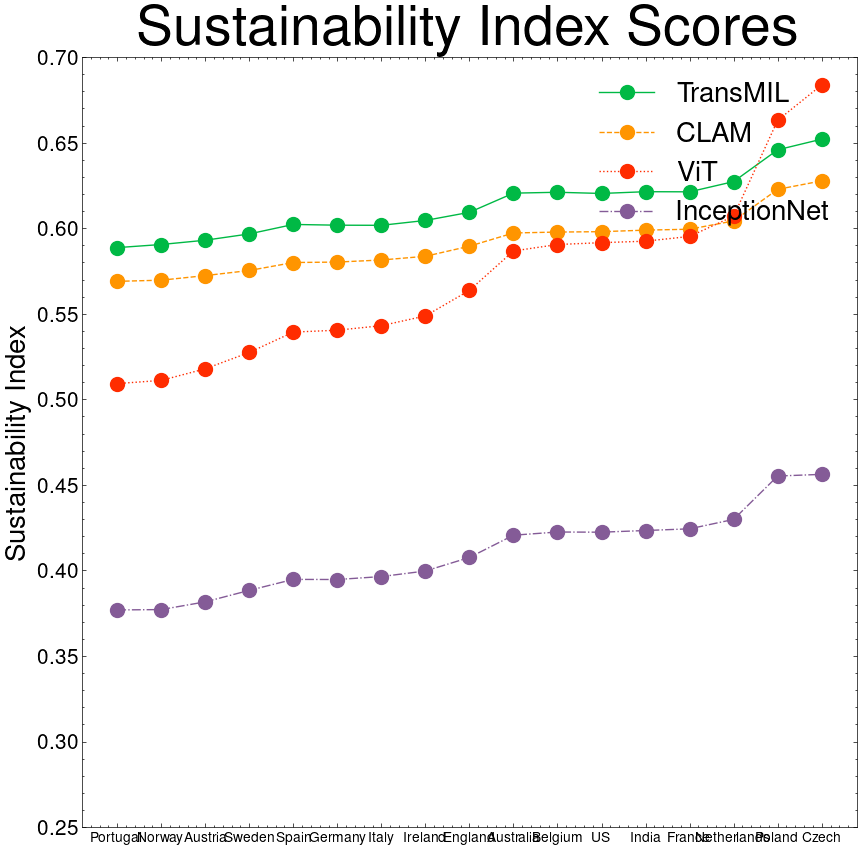

In [ ]:
# country_list
# from cycler import cycler
#si_out_dict
print(si_out_dict)
print(len(si_out_df.index))
line_styles = ['o-','o--','o:','o-.']
# for t in tasks:
with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(figsize=(10,10))
    for i in range(len(si_out_df.index)):
        
        model_rows = list(si_out_df.iloc[i])
        # print(list(model_rows))
        model_name = model_rows[0]
        if model_name == 'Inception':
            model_name = 'InceptionNet'
        model_series = model_rows[1:]
        # print(model_series)


        # co2_list = [co2_df.loc[co2_df.MODEL == m]['CO2eq'].values[0] for m in models]
        # # print(aucs)
        # print(co2_list)

        
        line1 = ax.plot(country_list, model_series,  line_styles[i], label=model_name, color=f'C{i+1}', ms=10) #'o-',
        # for k, value in enumerate(model_series):
        #     if i == 0:
        #         if k == 1:
        #             ax.text(tasks[k], model_series[k]-0.01, f'{model_series[k]:.2f}', va='top', ha='center', fontsize=20)
        #         else:
        #             ax.text(tasks[k], model_series[k]+0.01, f'{model_series[k]:.2f}', va='bottom', ha='center', fontsize=20)
        #     elif i == 1:
        #         if k == 1:
        #             ax.text(tasks[k], model_series[k]+0.01, f'{model_series[k]:.2f}', va='bottom', ha='center', fontsize=20)
        #         else:
        #             ax.text(tasks[k], model_series[k]-0.01, f'{model_series[k]:.2f}', va='top', ha='center', fontsize=20)

        #     else:
        #         ax.text(tasks[k], model_series[k]-0.01, f'{model_series[k]:.2f}', va='top', ha='center', fontsize=20)
            
        
        
    plt.legend(loc='upper right', fontsize=20)
    plt.title('Sustainability Index Scores', fontsize=40)
    plt.ylabel('Sustainability Index', fontsize=20)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=15)

        # # ax.scatter(aucs, co2_list)
        # ax.scatter(co2_list, aucs)

        # for i, txt in enumerate(models):
        #     ax.text(co2_list[i]+0.5, aucs[i], f'{aucs[i]:.2f} {txt}', va='center', ha='left')
        #     # ax.text(co2_list[i]+0.5, aucs[i], f'{aucs[i]:.2f} {txt}', va='center', ha='left')
        # ax.set_xlabel('CO2eq(g/Slide)')
        # ax.set_ylabel('AUC')
        # ax.set_xlim([15, 30])
    ax.set_ylim([0.25, 0.7])
        # ax.set_title(t)

        # break
    
    plt.savefig(f'{out_dir}/SI_plot.png', dpi=400)
    # plt.savefig(f'{paper_outdir}/SI_plot.png', dpi=400)
    plt.show()
    plt.close()

       Model    Norway   Austria    Sweden  Portugal     Spain  Germany   
0   TransMIL  0.003329  0.019058  0.028071  0.028128  0.034098   0.0345  \
1       CLAM  0.003320  0.019003  0.027989  0.028047  0.033999   0.0344   
2        ViT  0.009728  0.055683  0.082015  0.082183  0.099626   0.1008   
3  Inception  0.007441  0.042591  0.062732  0.062860  0.076202   0.0771   

      Italy   Ireland        US   England   Belgium    France  Netherlands   
0  0.035131  0.037428  0.040183  0.041389  0.045177  0.045579     0.046785  \
1  0.035030  0.037319  0.040067  0.041269  0.045046  0.045447     0.046649   
2  0.102645  0.109354  0.117404  0.120926  0.131996  0.133170     0.136692   
3  0.078511  0.083643  0.089800  0.092494  0.100961  0.101859     0.104553   

     Poland     Czech     India  
0  0.049827  0.050516  0.052927  
1  0.049683  0.050369  0.052773  
2  0.145581  0.147594  0.154638  
3  0.111352  0.112892  0.118280  


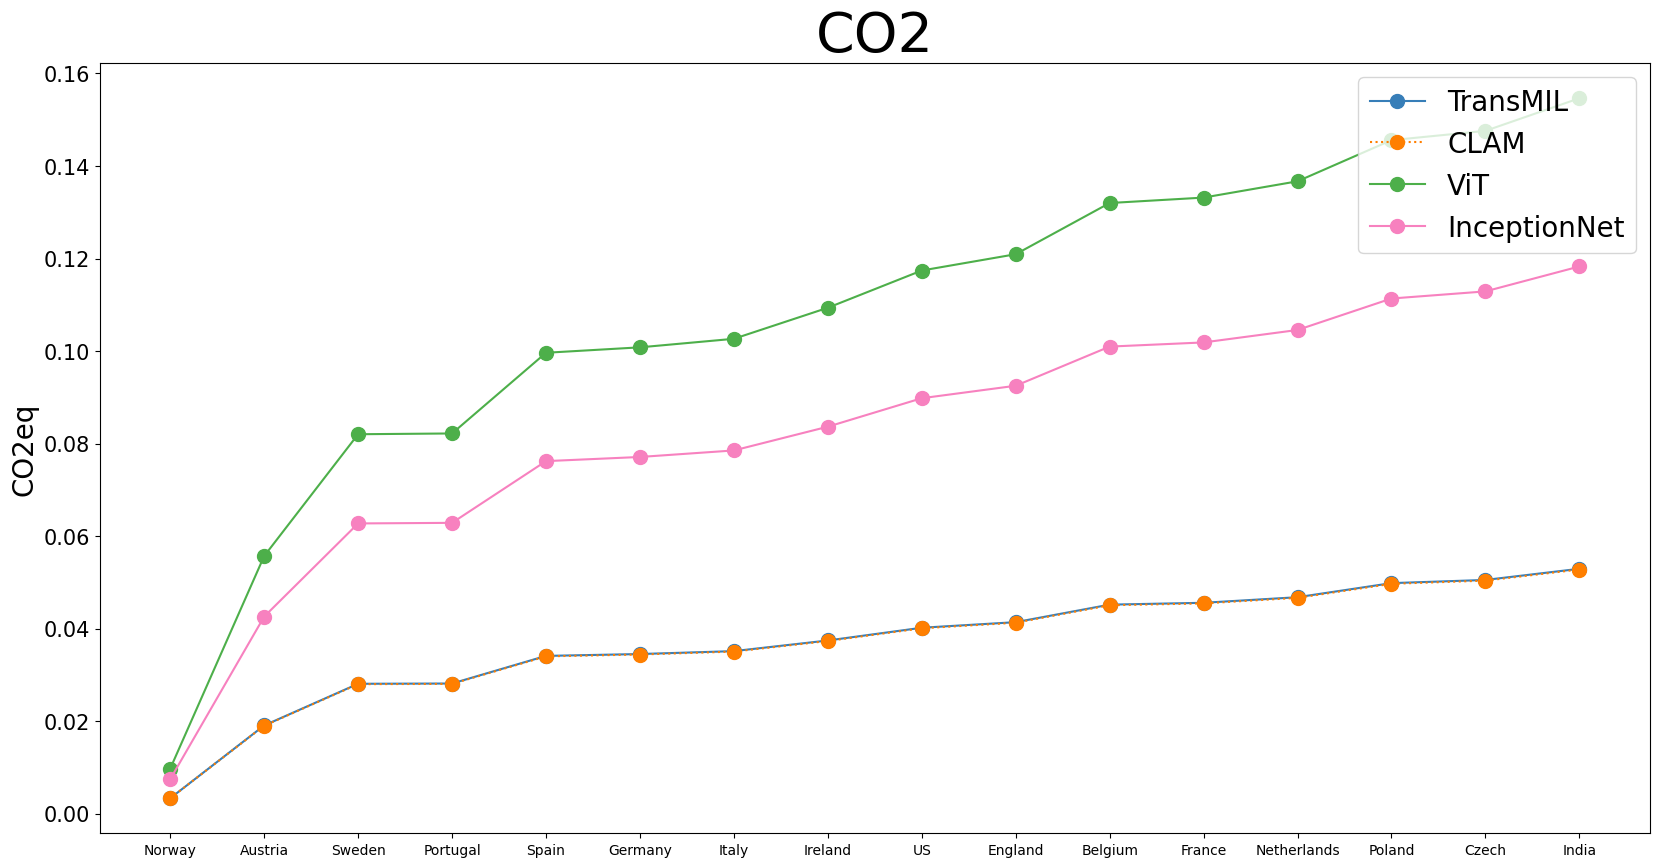

In [17]:
# country_list
# from cycler import cycler
#si_out_dict
COLOR_MAP = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# print(co2_out_df)
# print(len(si_out_df.index))
line_styles = ['o-','o:','o-','o-']
# for t in tasks:
# with plt.style.context(['science', 'nature']):
fig, ax = plt.subplots(figsize=(20,10))
for i in range(len(co2_out_df.index)):
    
    model_rows = list(co2_out_df.iloc[i])
    # print(list(model_rows))
    model_name = model_rows[0]
    if model_name == 'Inception':
        model_name = 'InceptionNet'
    model_series = model_rows[1:]
    # print(model_series)


    # co2_list = [co2_df.loc[co2_df.MODEL == m]['CO2eq'].values[0] for m in models]
    # # print(aucs)
    # print(co2_list)

    
    line1 = ax.plot(country_list, model_series,  line_styles[i], label=model_name, color=COLOR_MAP[i], ms=10) #'o-',
    # for k, value in enumerate(model_series):
    #     if i == 0:
    #         if k == 1:
    #             ax.text(tasks[k], model_series[k]-0.01, f'{model_series[k]:.2f}', va='top', ha='center', fontsize=20)
    #         else:
    #             ax.text(tasks[k], model_series[k]+0.01, f'{model_series[k]:.2f}', va='bottom', ha='center', fontsize=20)
    #     elif i == 1:
    #         if k == 1:
    #             ax.text(tasks[k], model_series[k]+0.01, f'{model_series[k]:.2f}', va='bottom', ha='center', fontsize=20)
    #         else:
    #             ax.text(tasks[k], model_series[k]-0.01, f'{model_series[k]:.2f}', va='top', ha='center', fontsize=20)

    #     else:
    #         ax.text(tasks[k], model_series[k]-0.01, f'{model_series[k]:.2f}', va='top', ha='center', fontsize=20)
        
    
    
plt.legend(loc='upper left', fontsize=20)
plt.title('CO2eq ', fontsize=40)
plt.ylabel('CO2eq', fontsize=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

    # # ax.scatter(aucs, co2_list)
    # ax.scatter(co2_list, aucs)

    # for i, txt in enumerate(models):
    #     ax.text(co2_list[i]+0.5, aucs[i], f'{aucs[i]:.2f} {txt}', va='center', ha='left')
    #     # ax.text(co2_list[i]+0.5, aucs[i], f'{aucs[i]:.2f} {txt}', va='center', ha='left')
    # ax.set_xlabel('CO2eq(g/Slide)')
    # ax.set_ylabel('AUC')
    # ax.set_xlim([15, 30])
# ax.set_ylim([0.25, 0.7])
    # ax.set_title(t)

    # break

# plt.savefig(f'{out_dir}/SI_plot.png', dpi=400)
# plt.savefig(f'{paper_outdir}/SI_plot.png', dpi=400)
plt.show()
plt.close()

In [21]:
## CO2 -> AUC plot

tasks = ['Normal_Disease', 'Rejection_Other', 'Normal_Rejection_Other']
# task_label = ['Normal vs Disease', 'Rejection vs Other', 'Normal vs Rejection vs Other']
COLOR_MAP = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
# pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
# print(pal)

for t in tasks:

    with plt.style.context(['science', 'nature']):
        aucs = list(out_df[t])
        # models = list(map(lambda x: x.replace('Inception', 'InceptionNet'), out_df.Model))
        models = list(out_df.Model)
        print(models)
        co2_list = [co2_df.loc[co2_df.MODEL == m]['CO2eq'].values[0] for m in models]

        dot_size = [model_params[m]*20 for m in models]
        # print(aucs)
        print(co2_list)

        fig, ax = plt.subplots(figsize=(10,10))
        # ax.scatter(aucs, co2_list)
        ax.scatter(co2_list, aucs, s=dot_size, color=['C1', 'C2', 'C3', 'C4']) #COLOR_MAP[:len(aucs)]

        for i, txt in enumerate(models):
            if txt == 'Inception':
                txt = 'InceptionNet'
            # if t == 'Rejection_Other' and i==0:
            #     # if i == 0:
            #     ax.text(co2_list[i]+0.005, aucs[i], f'{txt}', va='center', ha='left', fontsize=30, ma='left')
            # else:
            ax.text(co2_list[i]+0.005, aucs[i], f'{txt}', va='center', ha='left', fontsize=30, ma='left')

            # ax.text(co2_list[i]+0.5, aucs[i], f'{aucs[i]:.2f} {txt}', va='center', ha='left')
        ax.set_xlabel('CO2eq [g/Slide]', fontsize=30)
        ax.set_ylabel('AUROC', fontsize=30)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        ax.set_xlim([0.03, 0.12])
        # ax.set_ylim([0.5, 1.])
        ax.set_title(t.replace('_', ' vs '), fontsize=40)
        
        plt.savefig(f'{out_dir}/{t}_co2.png', dpi=400)
        plt.savefig(f'{paper_outdir}/{t}_co2.png', dpi=400)
        plt.show()
        plt.clf()


NameError: name 'out_df' is not defined

In [20]:
## CO2 -> AUC plot

tasks = ['Normal_Disease', 'Rejection_Other', 'Normal_Rejection_Other']
# task_label = ['Normal vs Disease', 'Rejection vs Other', 'Normal vs Rejection vs Other']
COLOR_MAP = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
# pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
# print(pal)

for t in tasks:

    with plt.style.context(['science', 'nature']):
        aucs = list(out_df[t])
        # models = list(map(lambda x: x.replace('Inception', 'InceptionNet'), out_df.Model))
        models = list(out_df.Model)
        print(models)
        co2_list = [co2_df.loc[co2_df.MODEL == m]['CO2eq'].values[0] for m in models]

        dot_size = [model_params[m]*20 for m in models]
        # print(aucs)
        print(co2_list)

        fig, ax = plt.subplots(figsize=(10,10))
        # ax.scatter(aucs, co2_list)
        ax.scatter(co2_list, aucs, s=dot_size, color=['C1', 'C2', 'C3', 'C4']) #COLOR_MAP[:len(aucs)]

        for i, txt in enumerate(models):
            if txt == 'Inception':
                txt = 'InceptionNet'
            # if t == 'Rejection_Other' and i==0:
            #     # if i == 0:
            #     ax.text(co2_list[i]+0.005, aucs[i], f'{txt}', va='center', ha='left', fontsize=30, ma='left')
            # else:
            ax.text(co2_list[i]+0.005, aucs[i], f'{txt}', va='center', ha='left', fontsize=30, ma='left')

            # ax.text(co2_list[i]+0.5, aucs[i], f'{aucs[i]:.2f} {txt}', va='center', ha='left')
        ax.set_xlabel('CO2eq [g/Slide]', fontsize=30)
        ax.set_ylabel('AUROC', fontsize=30)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        ax.set_xlim([0.03, 0.12])
        # ax.set_ylim([0.5, 1.])
        ax.set_title(t.replace('_', ' vs '), fontsize=40)
        
        plt.savefig(f'{out_dir}/{t}_co2.png', dpi=400)
        plt.savefig(f'{paper_outdir}/{t}_co2.png', dpi=400)
        plt.show()
        plt.clf()


NameError: name 'out_df' is not defined